In this notebooks all the content is study by using code provide by supervision document <br>
Link : https://supervision.roboflow.com/0.25.0/ 

In [1]:
%pip install ipywidgets --quiet

Note: you may need to restart the kernel to use updated packages.


In [9]:
# config 
HOME = "../../.."
MODEL = f"{HOME}/notebooks/models/yolov8x.pt"
IMAGE_PATH = f"{HOME}/data/raw/images"

In [2]:
from supervision.assets import download_assets, VideoAssets # to get the sample video 
import supervision as sv 
from ultralytics import YOLO
import numpy as np 
import cv2
import matplotlib.pyplot as plt # show image use 

In [3]:
# get sample video 
videoName = download_assets(VideoAssets.PEOPLE_WALKING)

videoName

  0%|          | 0/7606633 [00:00<?, ?it/s]

'people-walking.mp4'

In [4]:
import shutil

def fileMoving(source, destination) : 
    return shutil.move(source, destination) # will return destination path 

In [6]:
videoPath = fileMoving(source=f"./{videoName}", destination=f"{HOME}/data/raw/videos/")

videoPath

'C:/Users/LENOVO/OneDrive/Documents/GitHub/Crowd-Detection/data/raw/videos/people-walking.mp4'

In [7]:
# load model 
model = YOLO(MODEL)

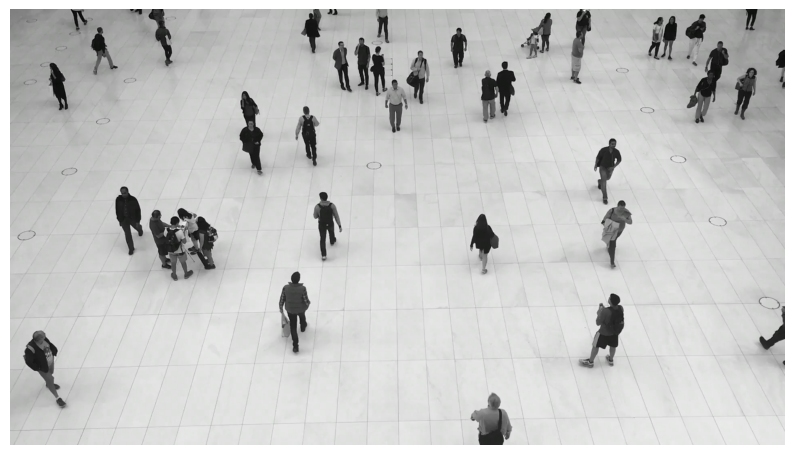

In [8]:
# get one frame from the video and display it 

# get frames iterator 
frames = sv.get_video_frames_generator(videoPath)

singleFrame = next(frames)

# show image
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(singleFrame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [9]:
# get the size of the picture 
# height, width, channels
singleFrame.shape

(1080, 1920, 3)

In [10]:
# draw a line with using Point 
start, end = sv.Point(x=0, y=540), sv.Point(x=1920, y=540)

line = sv.LineZone(start=start, end=end)

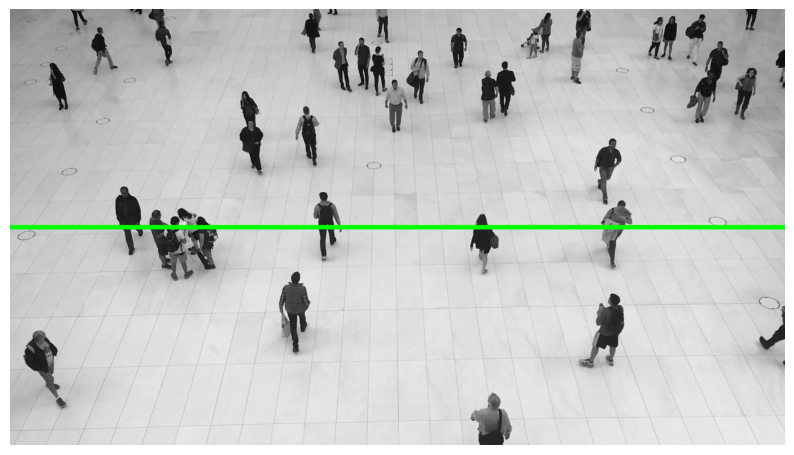

In [11]:
# draw the line and show on image 
frameWithLine = singleFrame.copy()

# draw line using start and end
frameWithLine = cv2.line(frameWithLine, (start.x, start.y), 
                         (end.x, end.y), color=(0, 255, 0), thickness=10)

# display 
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(frameWithLine, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


0: 384x640 21 persons, 672.9ms
Speed: 5.7ms preprocess, 672.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


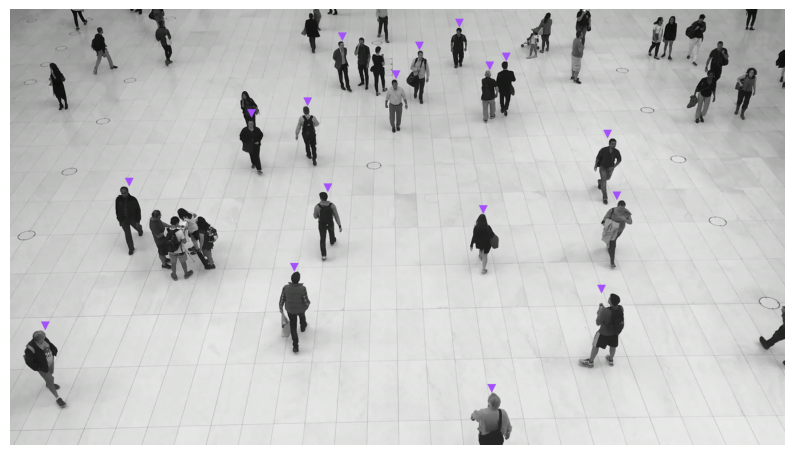

In [26]:
# apply bytetrack with triangle annotated

tracker = sv.ByteTrack()
triAnnotator = sv.TriangleAnnotator(height=20, base=20) # annotated

# do detection
result = model(singleFrame, classes=[0])[0]

# return result including xyxy, confidence, class for each object detect
detections = sv.Detections.from_ultralytics(result) 

detections = tracker.update_with_detections(detections)

# annotated with triangle mark
annotatedFrame = triAnnotator.annotate(scene=singleFrame.copy(), detections=detections)

# display 
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(annotatedFrame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

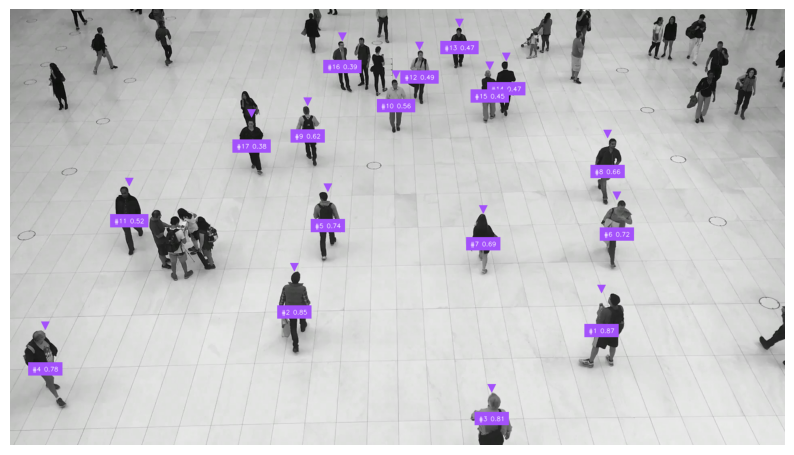

In [27]:
# add label annotated 
labels = [
    f"#{tracker_id} {confidence:.2f}"
    for confidence, tracker_id in zip(
        detections.confidence, detections.tracker_id
    )
]
labelAnnotator = sv.LabelAnnotator(text_position=sv.Position.CENTER)
annotatedFrame = labelAnnotator.annotate(scene=annotatedFrame, detections=detections, labels=labels)

# display 
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(annotatedFrame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [42]:
# combine line, bytetrack and annotator, display using opencv
from ultralytics import YOLO
import supervision as sv
import cv2
import numpy as np
from supervision import Position

# labeling 
tracker = sv.ByteTrack()
# boxAnnotator = sv.TriangleAnnotator(base=20, height=20)
boxAnnotator = sv.BoxAnnotator(thickness=1)
labelAnnotator = sv.LabelAnnotator(text_position=sv.Position.CENTER)

def annotated(frame: np.ndarray, detections: sv.Detections) -> np.ndarray :
    
    labels = [
        f"#{id} {confidence:.2f}"
        for id, confidence in zip(
            detections.tracker_id, detections.confidence
        )
    ]
    
    annotatedFrame = boxAnnotator.annotate(
        scene=frame.copy(),
        detections=detections
    )
    annotatedFrame = labelAnnotator.annotate(
        scene=annotatedFrame.copy(),
        detections=detections,
        labels=labels
    )
    return annotatedFrame

def calculateWindowSize(scale: float, cap: cv2.VideoCapture) -> np.int64 : 
    oriWidth, oriHeight = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    return int(oriWidth*scale), int(oriHeight*scale)

# x, y 
def textPosition(width: np.int64, height: np.int64) -> (np.int64) : 
    return (width - 200, height - 100)

# path to home
HOME = "../../.."

videoPath = f"{HOME}/data/raw/videos/people-walking.mp4"
modelPath = f"{HOME}/notebooks/models/yolov8x.pt"

model = YOLO(modelPath)

cap = cv2.VideoCapture(videoPath)

# calculate resize value and the center point of the video
newWidth, newHeight = calculateWindowSize(scale=0.5, cap=cap)
centerY = int(newHeight/2)

# line
start, end = sv.Point(x=0, y=centerY), sv.Point(x=newWidth, y=centerY)
line = sv.LineZone(start=start, end=end, minimum_crossing_threshold=0.5, triggering_anchors=(Position.BOTTOM_LEFT, Position.BOTTOM_RIGHT))
lineAnnotator = sv.LineZoneAnnotator(thickness=1, text_scale=0.5, text_thickness=1)

fps = int(cap.get(cv2.CAP_PROP_FPS))

while cap.isOpened() : 
    ret, frame = cap.read()
    if not ret :
        print("Video End")
        exit()

    # resize the frame 
    resizeFrame = cv2.resize(frame, (newWidth, newHeight))
    
    # detect
    result = model(resizeFrame, classes=[0])[0]

    # detections
    detections = sv.Detections.from_ultralytics(result)

    # update 
    detections = tracker.update_with_detections(detections)

    # get in out 
    goin, goout = line.trigger(detections)

    # draw annotated
    annotatedFrame = annotated(resizeFrame, detections)

    # draw line 
    annotatedFrame = lineAnnotator.annotate(annotatedFrame.copy(), line_counter=line)

    # text
    # texts = [f"Number of Human in frame = {len(detections.tracker_id)}", f"Out = {line.out_count}", f"In = {line.in_count}"]
    # cv2.putText(img=annotatedFrame, text=texts[0], org=textPosition(width=newWidth, height=newHeight), 
    #                     fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0,0,0), thickness=1)
    # cv2.putText(img=annotatedFrame, text=texts[1], org=textPosition(width=newWidth, height=newHeight+10), 
    #                     fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0,0,0), thickness=1)
    # cv2.putText(img=annotatedFrame, text=texts[2], org=textPosition(width=newWidth, height=newHeight+20), 
    #                     fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0,0,0), thickness=1)
    
    cv2.imshow("show", annotatedFrame)
    # Exit when 'q' is pressed
    if cv2.waitKey(5) & 0xFF == ord('q') :
        break

cap.release()
cv2.destroyAllWindows()


0: 384x640 28 persons, 1213.2ms
Speed: 3.8ms preprocess, 1213.2ms inference, 6.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 30 persons, 1046.3ms
Speed: 4.0ms preprocess, 1046.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 30 persons, 998.0ms
Speed: 4.0ms preprocess, 998.0ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 29 persons, 1055.5ms
Speed: 4.0ms preprocess, 1055.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 30 persons, 1039.6ms
Speed: 4.0ms preprocess, 1039.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 29 persons, 992.9ms
Speed: 3.0ms preprocess, 992.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 31 persons, 857.4ms
Speed: 4.0ms preprocess, 857.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 29 persons, 655.8ms
Speed: 2.0ms preprocess, 655.8ms inference, 1.0ms 

In [43]:
print(f"Trigger Called - In: {line.in_count}, Out: {line.out_count}")

Trigger Called - In: 0, Out: 0
